In [46]:
using ModelingToolkit, IntervalSets
using Sophon
using Optimization, OptimizationOptimJL

@parameters t, x
@variables u(..)
Dₓ = Differential(x)
Dₓ² = Differential(x)^2
Dₜ = Differential(t)

eq = Dₜ(u(x, t)) - 0.0001 * Dₓ²(u(x, t)) + 5 * u(x,t) * (abs2(u(x,t)) - 1.0) ~ 0.0

domain = [x ∈ -1.0..1.0, t ∈ 0.0..1.0]

bcs = [u(x,0) ~ x^2 * cospi(x),
       u(-1,t) ~ u(1,t)]

@named allen = PDESystem(eq, bcs, domain, [x, t], [u(x, t)])

PDESystem
Equations: Equation[5(abs2(u(x, t)) - 1.0)*u(x, t) + Differential(t)(u(x, t)) - 0.0001Differential(x)(Differential(x)(u(x, t))) ~ 0.0]
Boundary Conditions: Equation[u(x, 0) ~ (x^2)*cospi(x), u(-1, t) ~ u(1, t)]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, -1.0..1.0), Symbolics.VarDomainPairing(t, 0.0..1.0)]
Dependent Variables: Num[u(x, t)]
Independent Variables: Num[x, t]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [47]:
chain = FullyConnected(2, 1, tanh; hidden_dims=16, num_layers=5)
pinn = PINN(chain)
sampler = BetaRandomSampler(1000, (300, 100))
strategy = NonAdaptiveTraining(1, (50, 1))
prob = Sophon.discretize(allen, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [-1.263100266456604 0.5202279686927795; -0.38819342851638794 1.443336844444275; … ; -0.30498239398002625 0.11815711855888367; -0.6521449089050293 -0.42781493067741394], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.22294871509075165 0.5216359496116638 … 0.19422997534275055 -0.07057540118694305; 0.31677836179733276 0.2614767253398895 … -0.3950003683567047 0.5860685706138611; … ; -0.7197545766830444 -0.3009367883205414 … 0.4446689784526825 0.38387298583984375; -0.3614758849143982 -0.19744637608528137 … -0.475416362285614 -0.05143098160624504], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.4176279604434967 -0.6451348066329956 … -0.14643031358718872 0.5603060722351074; 0.24910232424736023 0.35847681760787964 … 0.23148678243160248 0.5776565670967102; … ; 0.16921724379062653 0.04811711981892586 … 0.6685226559638977 0.47197481989860535; 0.11119071394205093 -0.21565665304660797 … 0.38

In [48]:
i = 0
function callback(p, l)
    global i
    i%100==0 && println("Loss: $l")
    i += 1
    return false
end

res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

Loss: 55.52192681791724


Loss: 0.014472129540663372


Loss: 0.00828744525281614


Loss: 0.004968086028345163


Loss: 0.00043527163818910084


Loss: 0.0001561663404265384


Loss: 7.464075803484833e-5


Loss: 4.4919270344678794e-5


Loss: 2.8050082543726927e-5


Loss: 1.7814633305834836e-5


Loss: 1.3140809189113154e-5


u: ComponentVector{Float64}(layer_1 = (weight = [-1.3809440034288512 0.4637191267663868; -0.6789639965828589 1.684562538879801; … ; -0.0659857930250816 0.8458695423071817; 0.1229157145133369 -0.5324044807637043], bias = [0.11997605637033393; 1.4157460103102728; … ; 0.21074751027144067; -0.6684997976680502;;]), layer_2 = (weight = [0.5244414068216499 1.3544337534283608 … -0.005164886538071776 -0.1713460116635669; 0.3300920529134746 0.33141836853478107 … -0.011102683338483509 0.8594627916761548; … ; -0.7865031757085154 -0.43225744365647467 … 0.4455852315803516 0.014452532096042948; -0.16191724360887486 -0.2256182955263847 … -0.37566177819531815 -0.4283297670285689], bias = [-0.2629765220625127; 0.2749133123407331; … ; -0.31351327233587745; 0.638962505789902;;]), layer_3 = (weight = [0.5864862025912426 -0.6550619230145108 … -0.30116275565397227 0.8795489105047398; 0.41006984073187225 0.13564822817350558 … 0.37487220372658714 0.6779370966725274; … ; 0.04480284311308667 0.2673734615623705 …

In [49]:
using MAT
data = matread("AC.mat")

usol = data["uu"]

# Grid
t_star = vec(data["tt"])
x_star = vec(data["x"]);

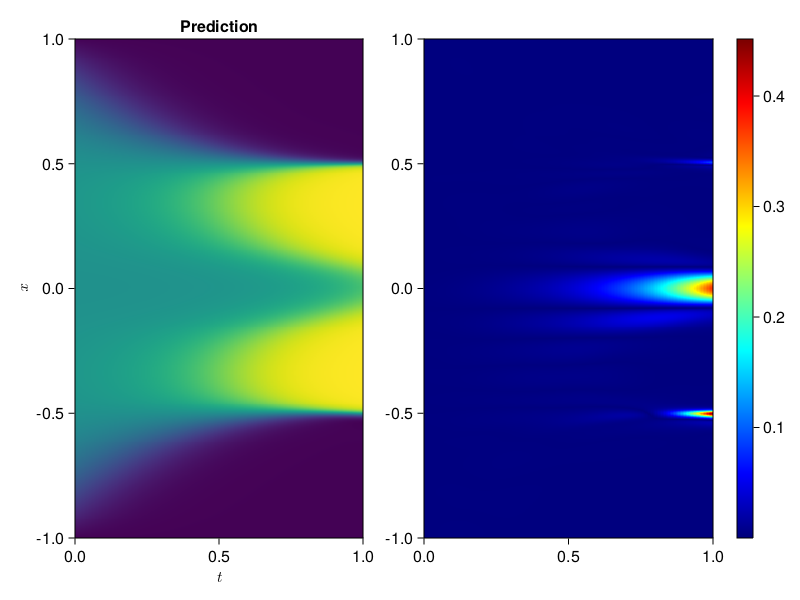

In [50]:
using CairoMakie, MakiePublication

phi = pinn.phi
xs, ts = [infimum(d.domain):0.01:supremum(d.domain) for d in allen.domain]
axis = (xlabel=L"t", ylabel=L"x", title="Prediction")
u_pred = [sum(pinn.phi([x, t], res.u)) for x in x_star, t in t_star]
fig,ax,hm =heatmap(ts, xs, u_pred', axis=axis)
ax2,hm2=heatmap(fig[:,end+1], ts, xs, abs.(u_pred' .- usol'), colormap=:jet)
Colorbar(fig[:, end+1], hm2)
fig

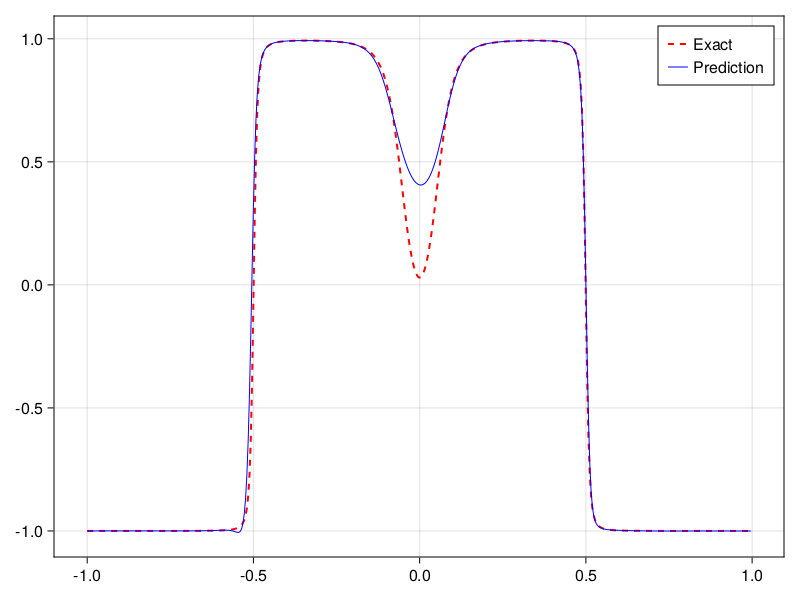

In [51]:
fig,ax,line = lines(x_star, usol[:,end], color=:red, linewidth=2, linestyle=:dash, label="Exact")
lines!(ax, x_star, u_pred[:,end], color=:blue, linewidth=1, label="Prediction")
axislegend(ax)
fig

Loss: 4.819719697105029e-5


Loss: 1.7451775089022972e-5


Loss: 1.2468560236305873e-5


Loss: 9.313601375477372e-6


Loss: 6.974642327199277e-6


Loss: 5.1923239368946555e-6


Loss: 4.146808004671861e-6


Loss: 3.3029868988746073e-6


Loss: 2.7007894254065577e-6


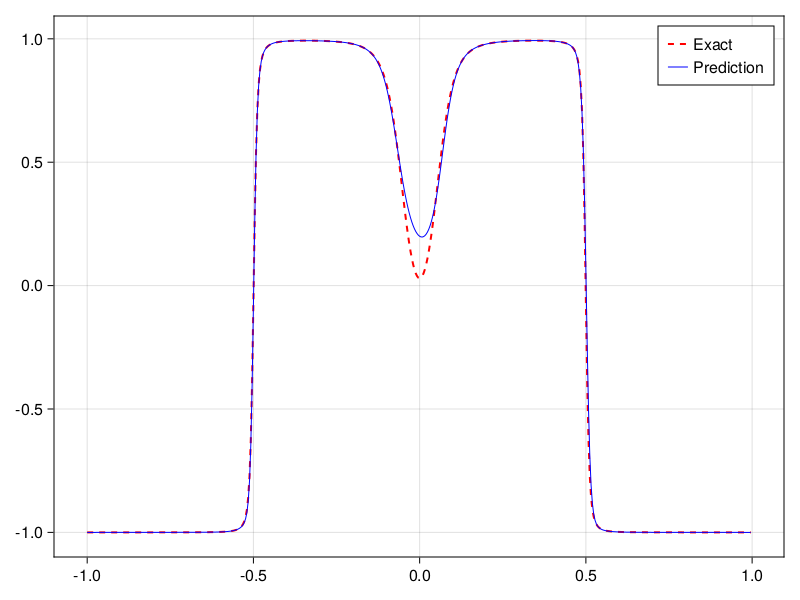

Loss: 2.2094477294184332e-6


Loss: 3.7840198391528714e-6


Loss: 2.5271088204064773e-6


Loss: 1.998392727861024e-6


Loss: 1.6476080884851769e-6


Loss: 1.4432337488619022e-6


Loss: 1.291120873935374e-6


Loss: 1.1450693897370126e-6


Loss: 1.029332666737626e-6


Loss: 9.403809913395108e-7


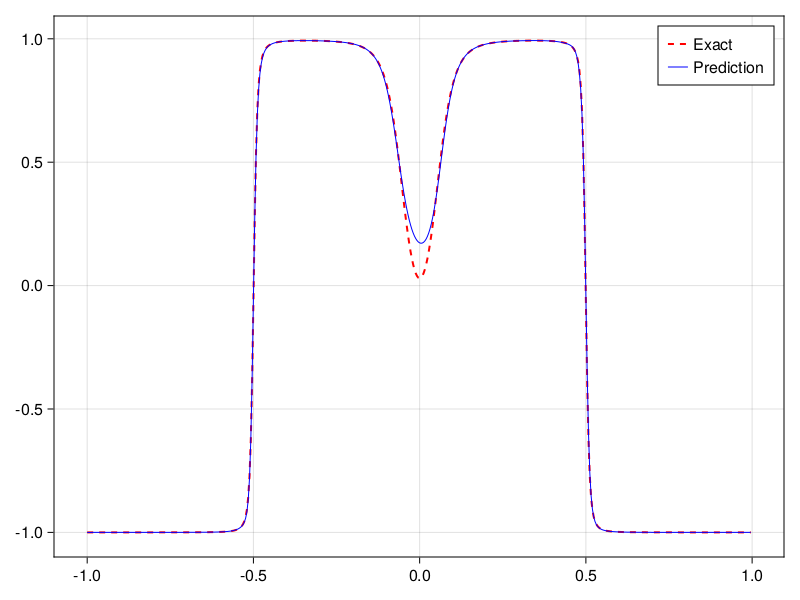

Loss: 8.557680858337254e-7


Loss: 3.141898312507965e-6


Loss: 1.9802197799090874e-6


Loss: 1.5331167994314045e-6


Loss: 1.3089927618977878e-6


Loss: 1.1556652614380063e-6


Loss: 1.039280686864085e-6


Loss: 9.300339581600012e-7


Loss: 8.592422125324799e-7


Loss: 7.917719971380427e-7


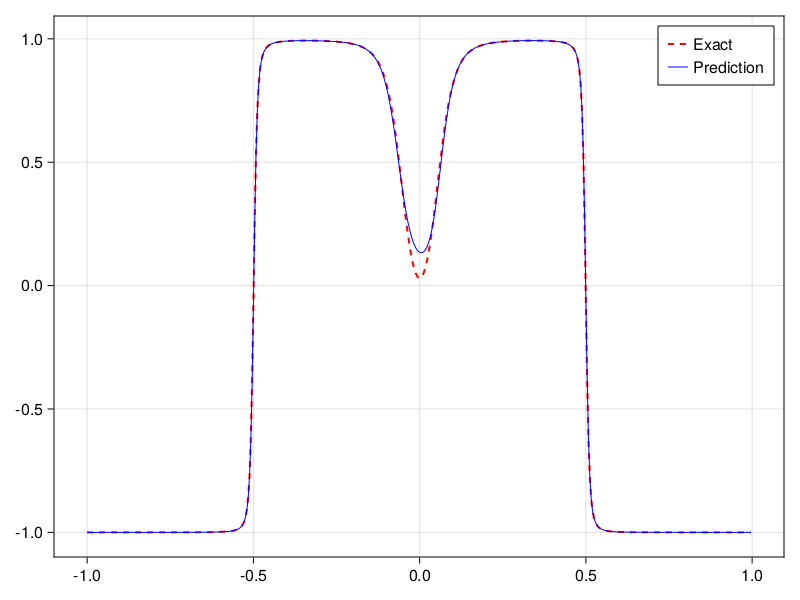

Loss: 7.319668141075438e-7


In [52]:
for α in [0.6, 0.8, 1.0] 
    sampler = remake(sampler; α=α)
    data = Sophon.sample(allen, sampler)
    prob = remake(prob; p=data, u0=res.u)
    res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

    u_pred = [sum(pinn.phi([x, t], res.u)) for x in x_star, t in t_star]
    fig, ax,line = lines(x_star, usol[:,end], color=:red, linewidth=2, linestyle=:dash, label="Exact")
    lines!(ax, x_star, u_pred[:,end], color=:blue, linewidth=1, label="Prediction")
    axislegend(ax)
    display(fig)
end


In [53]:
sampler = QuasiRandomSampler(2000, (300, 100))
data = Sophon.sample(allen, sampler)
prob = remake(prob; p=data, u0=res.u)
res = Optimization.solve(prob, BFGS(); maxiters=2000, callback=callback)

Loss: 1.543090900641273e-6


Loss: 1.191716521780953e-6


Loss: 1.0290776017611277e-6


Loss: 9.369136463430313e-7


Loss: 8.697156244900496e-7


Loss: 8.218566132902283e-7


Loss: 7.621237816363174e-7


Loss: 7.087360024492214e-7


Loss: 6.613044883395572e-7


Loss: 6.068774792882355e-7


Loss: 5.689153948524438e-7


Loss: 5.316945457178123e-7


Loss: 4.9308645414623e-7


Loss: 4.6826365657617125e-7


Loss: 4.3564655557285983e-7


Loss: 4.081777911255793e-7


Loss: 3.858135984429168e-7


Loss: 3.668092392936523e-7


Loss: 3.5178244361009916e-7


Loss: 3.288952034624636e-7


u: ComponentVector{Float64}(layer_1 = (weight = [-1.3771290685114697 0.18876474676771787; -0.6349728695901633 1.5830497627985398; … ; 0.048014935166280935 0.824161361627527; 0.20816829680294904 -0.4947968799349572], bias = [0.26273134682439314; 1.5571335827674424; … ; 0.26159111151086556; -0.7238257182830845;;]), layer_2 = (weight = [0.6161457871758983 1.4826931500181115 … 0.04447440000934023 -0.26104581923906645; 0.2683363233617822 0.3693247407676055 … 0.08751700248426973 0.8229163735670424; … ; -0.6642507728638314 -0.4632810652866726 … 0.403816047353344 0.03742400570304957; -0.1814060744092307 -0.24653981792398932 … -0.5251167079454052 -0.38020586961564523], bias = [-0.16117499159830642; 0.31699391554578793; … ; -0.33636499989982643; 0.5961550294678432;;]), layer_3 = (weight = [0.54585187029331 -0.7744024861804584 … -0.36737586494624014 0.911659823556265; 0.4473094441770723 0.251168376783545 … 0.27475437409320086 0.694611231096478; … ; 0.09386724426066942 0.44021902169441096 … 0.9471

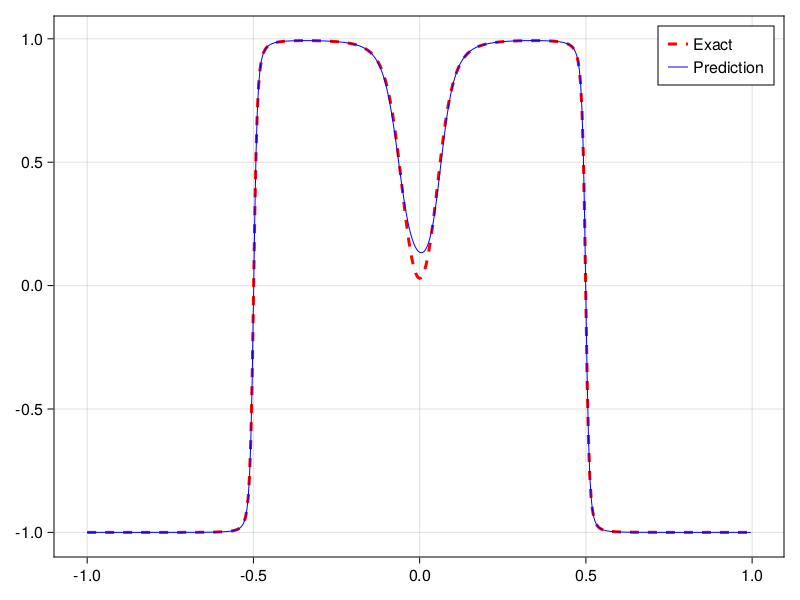

In [63]:
fig,ax,line = lines(x_star, usol[:,end], color=:red, linewidth=3, linestyle=:dash, label="Exact")
lines!(ax, x_star, u_pred[:,end], color=:blue, linewidth=1, label="Prediction")
axislegend(ax)
fig

In [56]:
using JLD2
jldsave("allen.jld2"; pde=allen, pinn=pinn, res=res, prob=prob)